# Machine Learning I - Practical I

Name: {Nathanael Schmidt-Ott}

Course: {Applied Statistics}

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Work in groups of three and hand in your solution as a group.

- Solutions need to be uploaded to StudIP until the submission date indicated in the course plan. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Solutions need to be presented to tutors in tutorial. Presentation dates are listed in the course plan. Every group member needs to be able to explain everything.

- You have to solve N-1 practicals to get admission to the exam.

- For plots you create yourself, all axes must be labeled. 

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [2]:
data = pd.read_csv('data/superconduct_train.csv')
print(data.shape)

(21263, 82)


In [3]:
data.head()
print(type(data))

<class 'pandas.core.frame.DataFrame'>


Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed.

In [4]:
# store the index of the target column 
target_clm = 'critical_temp'  # the critical temperature is our target variable
n_trainset = 200  # size of the training set
n_testset = 500  # size of the test set

In [5]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

# this one gets all rowindexes and randomly shuffels them
idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

# using the first 500 observations from the shuffled data for the test set
test_idx = idx_shuffled[:n_testset]
# using the following 200 observations for the training set or the remaining obeservations
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

# actually extracting the observations from the data for the test and training set
# the first argument specifies the rows to be selected, the second argument the columns.
X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):', X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):', X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatterplots** relating the target variable to one of the feature values. For this you will need 81 scatterplots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

Furthermore, we need to normalize the data, such that each feature has a mean of zero mean and a variance of one. Implement a function `normalize` which normalizes the data. Print the means and standard variation of the first five features before and after.

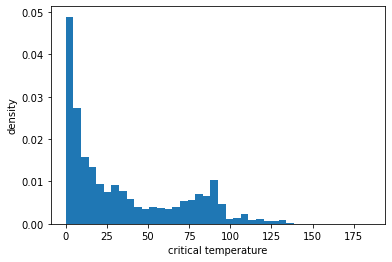

In [6]:
# Histogram of the target variable
plt.hist(y_train_full,bins = 40, density = True)
plt.xlabel("critical temperature")
plt.ylabel("density")
# this makes sure that only the plot it self is displayed, not the data
plt.show()

#help(plt.hist)

In [7]:
# get names of all covariates
x_var_names = list(data.columns)
target_idx = x_var_names.index(target_clm)

del x_var_names[target_idx]

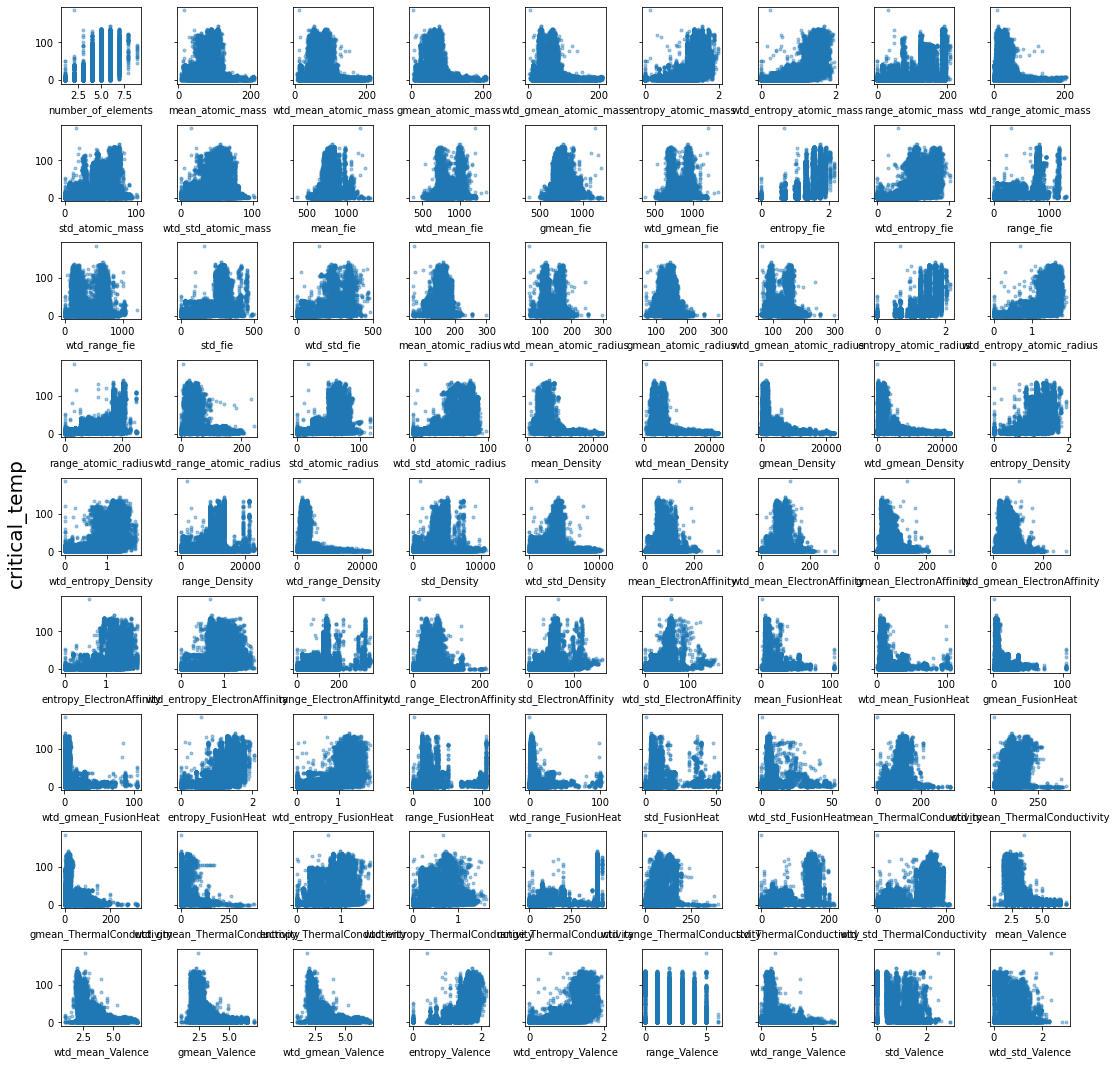

In [8]:
# Scatter plots of the target variable vs. features
#help(plt.scatter)

fig, ax = plt.subplots(9,9,sharey = True,figsize = (15,15))

fig.text(-0.01, .5,target_clm, fontsize = 20,va='center', rotation='vertical')
fig.tight_layout(pad = 2.0)

count_plot = 0
while count_plot < 81:
    count_y = 0
    while count_y < 9:
        count_x = 0
        while count_x < 9:
            ax[count_y,count_x].scatter(X_train_full[:,[count_plot]],y_train_full,marker = ".", alpha = .4)
            ax[count_y,count_x].set_xlabel(x_var_names[count_plot])
            count_x = count_x + 1
            count_plot = count_plot + 1
        count_y = count_y + 1  

In [10]:
# Normalize
def normalize(dat):
    norm = dat.copy()
    
    cols = norm.shape[1]
    for ii in range(cols):
        mean = np.mean(norm[:,ii])
        sd = np.std(norm[:,ii])
        
        norm[:,ii] = (norm[:,ii] - mean)/sd
    return norm

X_train_full_norm = normalize(X_train_full)

for ii in range(0,5):
    print("variable",ii,": mean before:",round(np.mean(X_train_full[:,[ii]]),2),
          "after:",round(np.mean(X_train_full_norm[:,[ii]]),2))
    print("variable",ii,": standarddeviation before:",round(np.std(X_train_full[:,[ii]]),2), 
          "after:",round(np.std(X_train_full_norm[:,[ii]]),2))

variable 0 : mean before: 4.11 after: -0.0
variable 0 : standarddeviation before: 1.44 after: 1.0
variable 1 : mean before: 87.61 after: -0.0
variable 1 : standarddeviation before: 29.7 after: 1.0
variable 2 : mean before: 73.05 after: 0.0
variable 2 : standarddeviation before: 33.56 after: 1.0
variable 3 : mean before: 71.34 after: 0.0
variable 3 : standarddeviation before: 31.08 after: 1.0
variable 4 : mean before: 58.6 after: -0.0
variable 4 : standarddeviation before: 36.73 after: 1.0


In [11]:
# actually normalise the data now

X_train = normalize(X_train)
X_test  = normalize(X_test)
X_train_full = normalize(X_train_full)

Which material properties may be useful for predicting superconductivity? What other observations can you make?

When looking at the plots, we aim at identifying correlations between the target variable and the predictors. This implies that we look for some trend in the plot (e.g. monotonically increasing values of the target with increasing values of the predictor or several peaks in the distribution). Some plots suggest that the respective covariates are good predictors of the target variable (critical temperature). For instance: the predictor entropy fusion heat suggests a linear increase in Y with increasing values. Moreover, wtd_range_fie plotted against CT appears to be bimodal and thus nicely splits the data into two different classes. 

In general, a lot of predictors seem to have more complex relations to the target variable. Thus, models with higher degrees of complexity than linear models might be appropriate to predict the target variable.

## Task 2:  Implement your own OLS estimator

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [12]:
def plot_regression_results(y_test, y_pred, weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram

    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''

    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('r^2: ', r2_score(y_test, y_pred))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # predicted vs true
    ax[0].scatter(y_test, y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error), bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights, bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  2640.432578444892
r^2:  -1.108062856115481


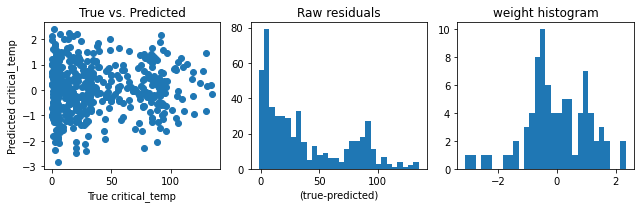

In [13]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_test = np.random.randn(y_test.size)

plot_regression_results(y_test, y_pred_test, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regession result, you should get mean squared error of 707.8.

In [16]:
def OLS_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------
    nobs_train = X_train.shape[0]
    
    # add intercept to the desgin matrix
    ones_train = np.ones((nobs_train,1))
    X = np.concatenate((ones_train,X_train),axis = 1)    
    
    X_t = np.transpose(X)
    XX = np.matmul(X_t,X)
    XX_inv = np.linalg.inv(XX)
    Y = y_train
    X_t_Y = np.matmul(X_t,Y)
    
    weights = np.matmul(XX_inv,X_t_Y)
    
    # create predictions for the test set
    nobs_test = X_test.shape[0]
    ones_test = np.ones((nobs_test,1))
    X_new = np.concatenate((ones_test,X_test),axis = 1)
    
    y_pred = np.matmul(X_new,weights)
    
    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  707.8008844810943
r^2:  0.43490745937581965


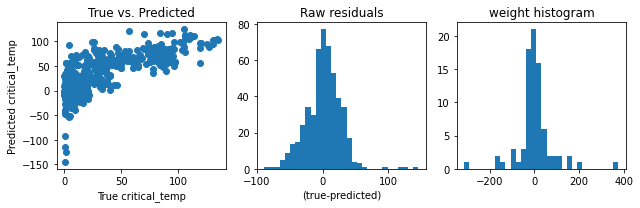

In [17]:
# Plots of the results
weights, y_pred = OLS_regression(X_test,X_train,y_train)
plot_regression_results(y_test,y_pred,weights)
 

What do you observe? Is the linear regression model good?

The overall performance of the linear model is moderate. The squared correlation between the predicted and the observed values is about 0.43. Interestingly, numerous predictors are assigned weights of close to zero. This suggests that their use in predicting the target variable is limited. Including variables that have no signal might lead to overfitting the training data and thus should be avoided. However, it is well possible that a lot of weights are close to zero, because the ratio of observations to predictors is quite high. Increasing the number of observations is likely to better disentangle noise and signal in the predictors. 

The residuals are roughly normally distributed around zero, suggesting that most predicted values are close to the observed values. 

Lastly, the linear model predicts several negative values, which are not possible since temperature is provided in Kelvin, which is bound at zero. Given this constraing, we should consider transforming the target variable using a log-transformation for instance.

## Task 3: Compare your implementation to sklearn

Now, familarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [15]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
    
    # create an object of linear regression type
    regression = linear_model.LinearRegression()
    regression.fit(X_train,y_train)
    weights = numpy.transpose(regression.coef_)
    
    y_pred = regression.predict(X_test)

    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  599.7397626148661
r^2:  0.5211810643358556


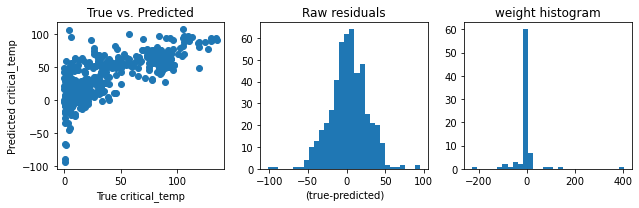

In [16]:
weights, y_pred = sklearn_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 707.8.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.86070104099656
r^2:  0.7366465263179409


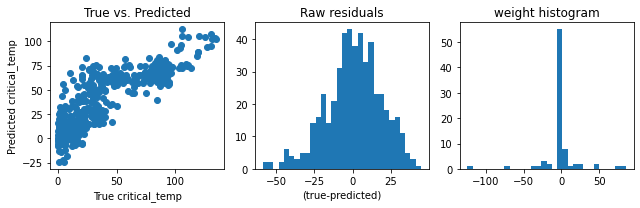

In [17]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

 How does test set performance change? What else changes?

The correlation between the predited and observed values increses substantially. The MSE also decreases substantially (which is equivalent to the squared correlation increasing). Nonetheless, there are still numerous predictors with weights at or around zero. As explained above, those predictors seem not to be very usefull for predicting the target variable.

## Task 4: Regularization with ridge regression

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [18]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha
       on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------
    nobs_train = X_train.shape[0]
    ones_train = np.ones((nobs_train,1))
    X = np.concatenate((ones_train,X_train),axis = 1)    
    d = X.shape[1]
    
    X_t = numpy.transpose(X)
    XX = numpy.matmul(X_t,X)
    
    I_d = np.identity(d)
    
    inv = numpy.linalg.inv(XX+(alpha*I_d))
    Y = y_train
    X_t_Y = numpy.matmul(X_t,Y)
    
    weights = numpy.matmul(inv,X_t_Y)
    
    # create predictions for the test set
    nobs_test = X_test.shape[0]
    ones_test = np.ones((nobs_test,1))
    X_new = np.concatenate((ones_test,X_test),axis = 1)
    
    y_pred = numpy.matmul(X_new,weights)

    # ---------------- END CODE -------------------------

    return weights, y_pred

Run the ridge regression on `X_train` with an alpha value of 10 and plot the obtained weights.

MSE:  429.7378500454349
r^2:  0.6569068239260808


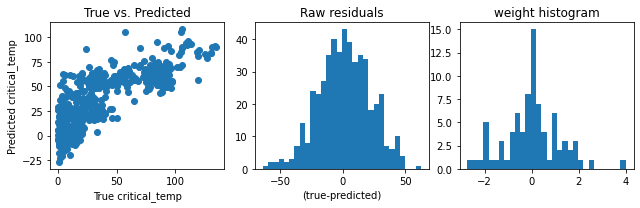

In [19]:
# Run ridge regression with alpha=10
weights, y_pred = ridge_regression(X_test,X_train,y_train,10)

# Plot regression results
plot_regression_results(y_test, y_pred, weights)

Now test a range of log-spaced $\alpha$s (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [20]:
alphas = np.logspace(-7, 7, 100)

# ---------------- INSERT CODE ----------------------
model_mse = []
model_weights = []
while len(model_mse) < len(alphas):
    current_alpha = alphas[len(model_mse)]
    weights,y_pred = ridge_regression(X_test,X_train,y_train,current_alpha)
    mse = mean_squared_error(y_test, y_pred)
    model_mse.append(mse)
    model_weights.append(weights)
# ---------------- END CODE -------------------------

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

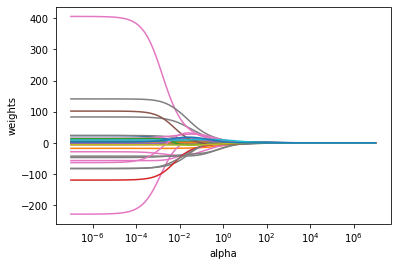

In [21]:
# Plot of coefficients vs. alphas
plt.plot()
for jj in range(0,X_train.shape[1]):
    plt.plot(alphas,np.array(model_weights)[:,jj])
    plt.xscale("log")
    plt.xlabel("alpha")
    plt.ylabel("weights")
plt.show()

Why are the values of the weights largest on the left? Do they all change monotonically? 

Ridge reression monotonically shrinks all weights except for the weight of the intercept to zero. Hence, on the far left, where alpha -> 0, the model is very similar to the full OLS model (including all predictors), while on the far right , where alpha -> inf the weights for all predictors tend to 0 and the model only includes the intercept, predicting the mean response for all observations. 

Plot how the performance (i.e. the error) changes as a function of $\alpha$. As a sanity check, the MSE value for very small $\alpha$s should be close to the test-set MSE of the unregularized solution, i.e. 708.

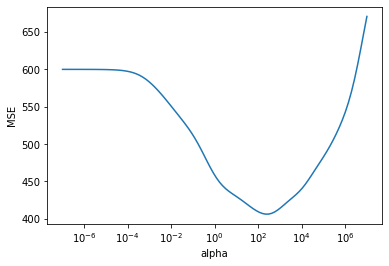

In [22]:
# Plot of MSE  vs. alphas
plt.plot(alphas,model_mse)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.show()

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~700 on the left?

The value alpha ~ 10^2 gives the minimum MSE. The curve should approach ~700 on the left, since for alpha -> 0, the model approaches the unregularised model and the estimated MSE for the unregulated model is ~ 700.

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [23]:
def ridge_regression_sklearn(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
    alpha_float = float(alpha)
    regression = linear_model.Ridge(alpha_float)
    regression.fit(X_train,y_train)
    weights = numpy.transpose(regression.coef_)
    
    y_pred = regression.predict(X_test)
    # ---------------- END CODE -------------------------

    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

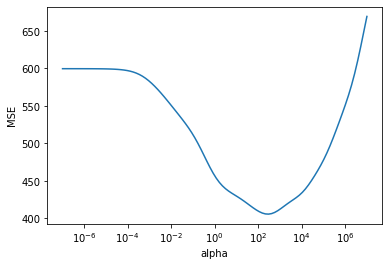

In [24]:
# Plot of MSE  vs. alphas
mse_model = []
while len(mse_model) < len(alphas):
    count = len(mse_model)
    weights,y_pred = ridge_regression_sklearn(X_test,X_train,y_train,alphas[count])
    mse_model.append(mean_squared_error(y_test,y_pred))

plt.plot(alphas,mse_model)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.show()

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [66]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha.
       The function should train the linear regression model for each fold on all values of alpha.

      Inputs:
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over

      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold

      Note:
        Fix the seed for reproducibility.
    '''

    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    # ---------------- INSERT CODE ----------------------
    idx = np.arange(X.shape[0])
    folds = np.array_split(idx,n_folds)
    
    for ii in np.arange(len(alphas)):
        alpha = alphas[ii]
        for jj in np.arange(n_folds):
            # get training and test indexes
            idx_train = folds.copy() 
            idx_test = idx_train[jj]
            del idx_train[jj]
            idx_train = np.concatenate(idx_train).ravel()

            X_train =  X[idx_train,:]
            X_test = X[idx_test,:]

            y_train = y[idx_train]
            y_test = y[idx_test]

            weights, y_pred = ridge_regression_sklearn(X_test,X_train,y_train,alpha)

            mse = mean_squared_error(y_test,y_pred)

            cv_results_mse[jj,ii] = mse

    # ---------------- END CODE -------------------------

    return cv_results_mse

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [69]:
alphas = np.logspace(-7, 7, 100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

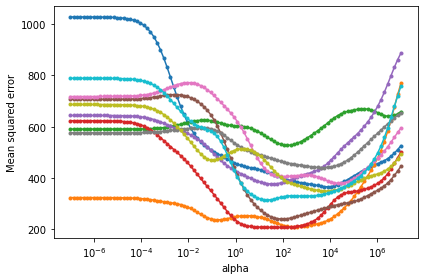

In [68]:
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

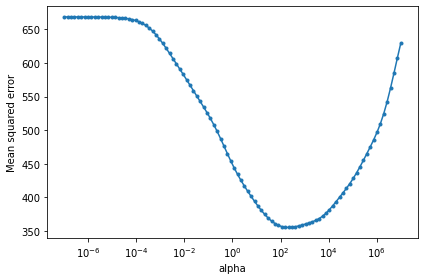

In [80]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

the optimal value for alpha is ~ 10^2, which is the same as for the test set approach! However, cross validation has higher error estimates for low values of alpha and lower error estimates for higher values of alpha. In particular, the minimal error estimate is lower in the cross validation setting than it is in the testset approach.

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [81]:
alphas = np.logspace(-7, 7, 100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

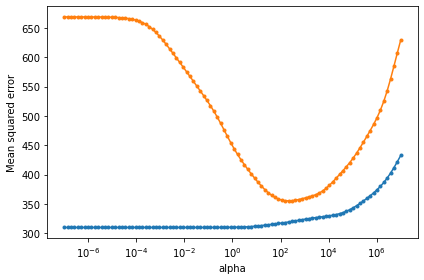

In [82]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We zoom in on the blue curve to the very left:

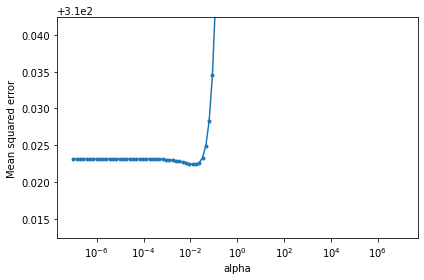

In [84]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full, axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

In [86]:
X_train_full.shape

(20763, 81)

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

The curves look so different because CV curve based on the full training data, has about 100 times as many data points as the small training set. The more data there is, the easier it becomes to distinguish noise from signal. In the small training set, the ratio of covariates to observations is substantially higher than for the full training sample. 

The optimal value for the full training sample is ~ 10^-2, since it minimises the error term. The reason for this is explained above!